# AI Project - Team 2
## 🌱Plant Disease Classification Using EfficientNet

## 🚀 Why This Project?

Manual plant disease detection is slow and requires experts. Automating this using AI can save time and improve accuracy.

# ⚒ Imports
Import essential libraries for data loading, model building, training, visualization, and UI interaction.

In [ ]:
import os
import json
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import kagglehub
from google.colab import drive
import torch.nn.functional as F
import random
import numpy as np
from torchvision.models import efficientnet_b0
from PIL import Image
from IPython.display import display
import ipywidgets as widgets
import io

# 📦 Dataset Download
Download dataset from Kaggle and mount Google Drive for saving models and history.

The dataset contains over 87,000 augmented images of healthy and diseased leaves from various crops.

In [ ]:
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/new-plant-diseases-dataset


In [ ]:
drive.mount("/content/drive")
COLAB_DRIVE_DIR = "/content/drive/MyDrive/PlantDiseaseModel"
os.makedirs(COLAB_DRIVE_DIR, exist_ok=True)

Mounted at /content/drive


# 🔧 Configuration

Set up paths, hyperparameters, and device configuration.

In [ ]:
DATASET_DIR = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VALID_DIR = os.path.join(DATASET_DIR, "valid")
TEST_DIR = "/kaggle/input/new-plant-diseases-dataset/test/test"
BATCH_SIZE = 32
NUM_WORKERS = 4
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Extended configuration for training loop

In [ ]:
EPOCHS = 10
MAX_LR = 0.01
GRAD_CLIP = 0.1
WEIGHT_DECAY = 1e-4
OPT_FUNC = 'adam'
RANDOM_SEED = 7
MODEL_FILENAME = "efficientnet_b0_plant_disease.pth"
HISTORY_FILENAME = "training_history.json"

# 🧠 Data Preparation

Define data loading and preprocessing steps.

In [ ]:
class DeviceDataLoader:
    # Moves data batches to the specified device (CPU or GPU).
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for images, labels in self.dl:
            yield images.to(self.device), labels.to(self.device)
    def __len__(self): return len(self.dl)

Define consistent image transformations for training and validation

In [ ]:
train_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Load training and validation data

In [ ]:
def get_data_loaders(train_dir, valid_dir, batch_size, seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    train_ds = datasets.ImageFolder(train_dir, transform=train_val_transform)
    valid_ds = datasets.ImageFolder(valid_dir, transform=train_val_transform)
    return (
        DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True),
        DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True),
        train_ds.classes
    )

Loaders ready to be used for training

In [ ]:
train_loader, valid_loader, class_names = get_data_loaders(TRAIN_DIR, VALID_DIR, BATCH_SIZE, RANDOM_SEED)
train_loader = DeviceDataLoader(train_loader, DEVICE)
valid_loader = DeviceDataLoader(valid_loader, DEVICE)

# 🏗️ Model Definition

Accuracy helper

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Base model with reusable training/validation logic

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        return F.cross_entropy(self(images), labels)

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        return {
            'val_loss': F.cross_entropy(out, labels).detach(),
            'val_accuracy': accuracy(out, labels)
        }

    def validation_epoch_end(self, outputs):
        losses = [x['val_loss'] for x in outputs]
        accs = [x['val_accuracy'] for x in outputs]
        return {
            'val_loss': torch.stack(losses).mean(),
            'val_accuracy': torch.stack(accs).mean()
        }

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], Train Loss: {result['train_loss']:.4f}, Val Loss: {result['val_loss']:.4f}, Val Acc: {result['val_accuracy']:.4f}")


Final model using EfficientNetB0 backbone


*   EfficientNetB0 is chosen for its balance between accuracy and computational efficiency



In [ ]:
class PlantDiseaseModel(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.network = efficientnet_b0(weights=None)
        self.network.classifier[1] = nn.Linear(self.network.classifier[1].in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)


In [ ]:
def get_model(num_classes):
    return PlantDiseaseModel(num_classes).to(DEVICE)

model = get_model(len(class_names))

# ⚙️ Training and Evaluation Functions

Evaluate model on validation set

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    return model.validation_epoch_end([model.validation_step(batch) for batch in val_loader])

Full training loop using one-cycle learning rate policy


*   Gradient clipping and weight decay improve training stability and generalization



In [ ]:
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    history = []
    for epoch in range(epochs):
        model.train()
        train_losses, lrs = [], []
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            train_losses.append(loss)
            lrs.append(optimizer.param_groups[0]['lr'])
            sched.step()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history


# 📈 Visualization

Plotting helpers for loss, accuracy, and learning rate

In [ ]:
def plot_accuracies(history):
    plt.plot([x['val_accuracy'] for x in history], '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.show()

In [ ]:
def plot_losses(history):
    train_losses = [x['train_loss'] for x in history if 'train_loss' in x]
    val_losses = [x['val_loss'].cpu() if isinstance(x['val_loss'], torch.Tensor) else x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()


In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x['lrs'] for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch')
    plt.ylabel('LR')
    plt.title('LR Schedule')
    plt.show()

# 📁 Save Training History

Save training metrics as JSON for later inspection or reuse

In [ ]:
def save_history(history, filename):
    with open(filename, "w") as f:
        json.dump([
            {
                "val_loss": round(x['val_loss'].item() if isinstance(x['val_loss'], torch.Tensor) else x['val_loss'], 6),
                "val_accuracy": round(x['val_accuracy'].item() if isinstance(x['val_accuracy'], torch.Tensor) else x['val_accuracy'], 6),
                "train_loss": round(x['train_loss'], 6),
                "lrs": [round(lr, 8) for lr in x['lrs']]
            } for x in history
        ], f, indent=2)


# 🏃 Run Training

Train the model if not already saved; otherwise, load existing model and history

In [ ]:
FORCE_TRAIN = False
history = []
if not os.path.exists(MODEL_FILENAME) or FORCE_TRAIN:
    print("Training new model...")
    history = fit_one_cycle(EPOCHS, MAX_LR, model, train_loader, valid_loader,
                            grad_clip=GRAD_CLIP, weight_decay=WEIGHT_DECAY,
                            opt_func=torch.optim.Adam if OPT_FUNC=='adam' else torch.optim.SGD)
    torch.save(model.state_dict(), MODEL_FILENAME)
    print(f"Model saved to {MODEL_FILENAME}")
    save_history(history, HISTORY_FILENAME)
    print(f"Training history saved to {HISTORY_FILENAME}")
else:
    model.load_state_dict(torch.load(MODEL_FILENAME))
    print("Model loaded from drive.")
    if os.path.exists(HISTORY_FILENAME):
        with open(HISTORY_FILENAME, "r") as f:
            history = json.load(f)
        for x in history:
            x['val_loss'] = torch.tensor(x['val_loss'])
            x['val_accuracy'] = torch.tensor(x['val_accuracy'])
        print(f"Training history loaded from {HISTORY_FILENAME}")

Model loaded from drive.


In [ ]:
if history:
    plot_accuracies(history)
    plot_losses(history)
    plot_lrs(history)

# 🧪 Inference on Test Images

Use trained model to predict labels on unseen test images

In [ ]:
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
def predict_image(img_tensor, model):
    model.eval()
    xb = img_tensor.unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return class_names[preds[0].item()]

In [ ]:
test_images = sorted(os.listdir(TEST_DIR))
results = []
for fname in test_images:
    img_path = os.path.join(TEST_DIR, fname)
    img = Image.open(img_path).convert('RGB')
    img_tensor = inference_transform(img)
    pred_class = predict_image(img_tensor, model)
    results.append({"filename": fname, "prediction": pred_class})
    print(f"File: {fname}, Predicted Class: {pred_class}")

File: AppleCedarRust1.JPG, Predicted Class: Apple___Cedar_apple_rust
File: AppleCedarRust2.JPG, Predicted Class: Apple___Cedar_apple_rust
File: AppleCedarRust3.JPG, Predicted Class: Apple___Cedar_apple_rust
File: AppleCedarRust4.JPG, Predicted Class: Apple___Cedar_apple_rust
File: AppleScab1.JPG, Predicted Class: Apple___Apple_scab
File: AppleScab2.JPG, Predicted Class: Apple___Apple_scab
File: AppleScab3.JPG, Predicted Class: Apple___Apple_scab
File: CornCommonRust1.JPG, Predicted Class: Corn_(maize)___Common_rust_
File: CornCommonRust2.JPG, Predicted Class: Corn_(maize)___Common_rust_
File: CornCommonRust3.JPG, Predicted Class: Corn_(maize)___Common_rust_
File: PotatoEarlyBlight1.JPG, Predicted Class: Potato___Early_blight
File: PotatoEarlyBlight2.JPG, Predicted Class: Potato___Early_blight
File: PotatoEarlyBlight3.JPG, Predicted Class: Potato___Early_blight
File: PotatoEarlyBlight4.JPG, Predicted Class: Potato___Early_blight
File: PotatoEarlyBlight5.JPG, Predicted Class: Potato___Ea

In [ ]:
df = pd.DataFrame(results)
df.to_csv("predictions.csv", index=False)
print("\n✅ All predictions saved to predictions.csv")


✅ All predictions saved to predictions.csv


# 💻 Image Upload Widget for Live Inference

Allows user to upload an image in notebook and see prediction immediately

In [ ]:
def predict_uploaded_image(img_tensor):
    xb = img_tensor.unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return class_names[preds[0].item()]

In [ ]:
def on_image_upload(change):
    uploaded_file = next(iter(change['new'].values()))
    content = uploaded_file['content']
    img = Image.open(io.BytesIO(content)).convert('RGB')
    tensor = inference_transform(img)
    pred_class = predict_uploaded_image(tensor)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class}")
    plt.show()
    print("Predicted Class:", pred_class)

Label(value='📷 Upload a plant image for prediction:')

FileUpload(value={}, accept='image/*', description='Upload')

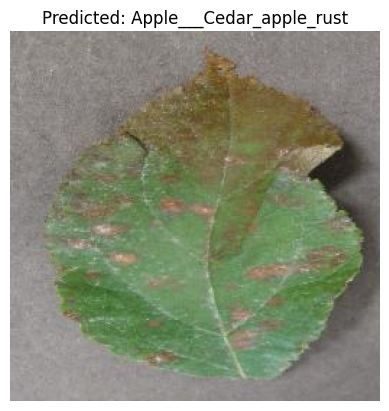

Predicted Class: Apple___Cedar_apple_rust


In [ ]:
uploader = widgets.FileUpload(accept='image/*', multiple=False)
uploader.observe(on_image_upload, names='value')

display(widgets.Label("📷 Upload a plant image for prediction:"))
display(uploader)